In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from torch.nn import functional as F
import mlflow as mlflow
%matplotlib inline

In [47]:
torch.backends.mps.is_available()

True

In [48]:
names = open("../datasets/llm/names.txt",mode="r",encoding="utf8").read().splitlines()
names[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [49]:
vocab = "".join(sorted(set(x for word in names+["."] for x in word))) # building vocab

In [50]:
len(vocab)

27

In [51]:
stoi = {k:v for v,k in enumerate(vocab)}
itos = {v:k for v,k in enumerate(vocab)}

In [198]:
torch.set_default_device("cpu")
def build_dataset(data, n_context):
    xs = []
    ys = []
    
    for x in data:
        context = [0]* n_context
        for ch in x + ".":
            # print(f"{context} {stoi[ch]}")
            ix = stoi[ch]
            xs.append(context)
            ys.append(ix)
            context = context[1:]+[ix]
    xs = torch.tensor(xs)
    ys = torch.tensor(ys)
    print(xs.shape,ys.shape)
    return xs,ys

np.random.shuffle(names)

data_size =  len(names)
n_context = 3
train_data = names[:int(data_size * .8)]
dev_data = names[int(data_size * .8):int(data_size * .9)]
test_data = names[int(data_size * .9):]

Xtr,Ytr = build_dataset(train_data,n_context) 
Xdev,Ydev = build_dataset(dev_data,n_context)
Xtest,Ytest = build_dataset(test_data,n_context)

torch.Size([182684, 3]) torch.Size([182684])
torch.Size([22717, 3]) torch.Size([22717])
torch.Size([22745, 3]) torch.Size([22745])


In [199]:
Xtr

tensor([[ 0,  0,  0],
        [ 0,  0, 10],
        [ 0, 10, 15],
        ...,
        [ 0, 10,  1],
        [10,  1, 14],
        [ 1, 14,  1]])

In [239]:
e_dim = 10
h_dim = 200
g = torch.Generator().manual_seed(2147483647)
C = torch.randn(len(vocab), e_dim, generator=g) # character embeddings with dimension of e_dim
W1 = torch.randn(n_context*e_dim, h_dim, generator=g) #* (5/3) /((e_dim * n_context)**0.5) # kammit init
b1 = torch.randn(h_dim, generator=g) * 0.01
W2 = torch.randn(h_dim,len(vocab), generator=g) * 0.01
b2 = torch.randn(len(vocab), generator=g) * 0

bgain = torch.ones((1,h_dim))
bbias = torch.zeros((1,h_dim))
bmeanrunning = torch.zeros((1,h_dim))
bstdrunning = torch.ones((1,h_dim))

parameters = [C,W1,b1,W2,b2,bgain,bbias]

In [240]:
lrs = torch.linspace(-3,1,20)
loglrs = 10**lrs

In [241]:
lossi = []
rsloss = []

In [242]:
sum( p.nelement() for p in parameters)

12297

In [243]:
for p in parameters:
    p.requires_grad = True

In [244]:

t = time.time()
batch_size = 32
lrsloss = []
for i in range(200000):
    #forward pass
    ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xtr[ix]]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    bmeani = preh.mean(0,keepdim=True)
    bstdi = preh.std(0,keepdim = True)
    preh = bgain*(preh - bmeani)/ bstdi + bbias
    with torch.no_grad():
        bmeanrunning = 0.999 * bmeanrunning + 0.001 * bmeani
        bmeanrunning = 0.999 * bstdrunning + 0.001 * bstdi
        
    h =  torch.tanh(preh)
    out = h @ W2 + b2
    loss = F.cross_entropy(out,Ytr[ix])
    lossi.append(loss.item())
    if i % 10000 == 0:
        print(F"loss at {i}/200000 {loss.item():.4f}")
    for p in parameters:
        p.grad = None 
    #backpass
    loss.backward()
    
    #update
    lr = 0.1 if i <100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
print(F"Mins taken: {(t - time.time())/60}")
print(F" Final loss: {loss.item():.4f}")


loss at 0/200000 3.3069
loss at 10000/200000 2.3789
loss at 20000/200000 2.3516
loss at 30000/200000 2.2254
loss at 40000/200000 2.3253
loss at 50000/200000 2.1646
loss at 60000/200000 1.8788
loss at 70000/200000 2.2700
loss at 80000/200000 2.1885
loss at 90000/200000 2.3038
loss at 100000/200000 2.0505
loss at 110000/200000 2.5955
loss at 120000/200000 2.2372
loss at 130000/200000 2.0133
loss at 140000/200000 1.7310
loss at 150000/200000 1.9859
loss at 160000/200000 2.2209
loss at 170000/200000 1.9710
loss at 180000/200000 2.2870
loss at 190000/200000 1.7024
Mins taken: -1.4599177678426107
 Final loss: 1.9955


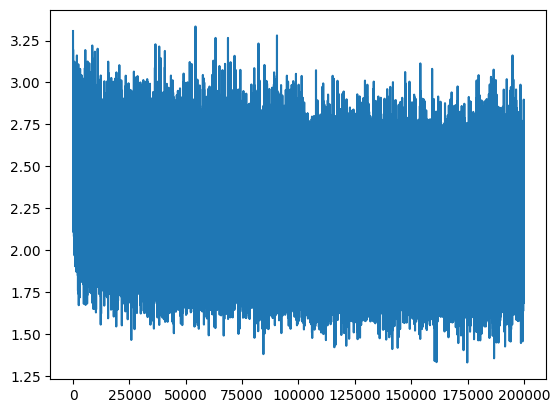

In [246]:
plt.plot(lossi)

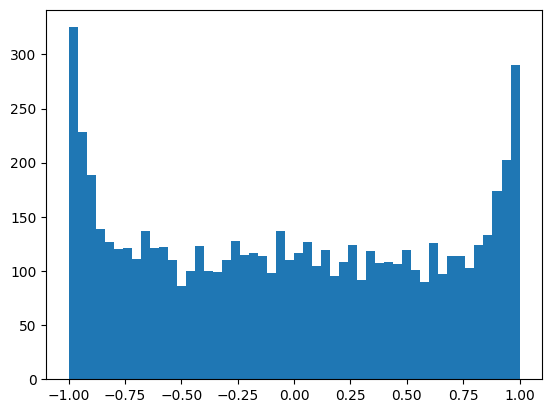

In [247]:
plt.hist(h.view(-1).data,bins=50)
plt.show()

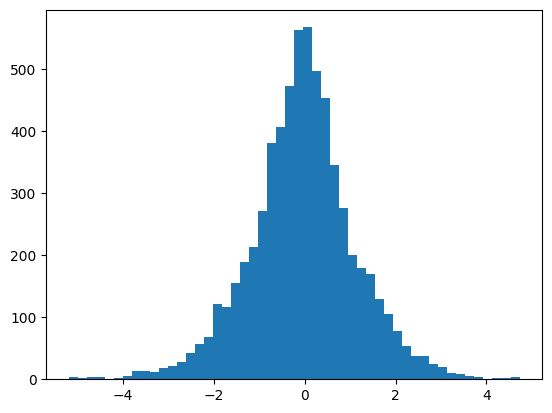

In [248]:
plt.hist(preh.view(-1).data,bins=50)
plt.show()

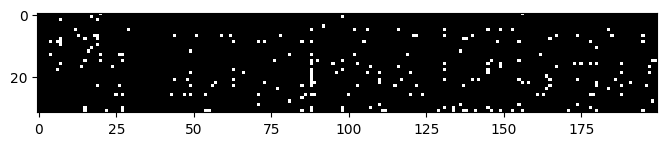

In [249]:
plt.figure(figsize=(8,8))
plt.imshow(h.abs() > .99,cmap="grey",interpolation="nearest");

In [250]:
with torch.no_grad():
    emb = C[Xtr]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    bmean = preh.mean(0,keepdim=True)
    bstd = preh.std(0,keepdim = True)
    

In [251]:
#dev validation
with torch.no_grad():
    # ix = torch.randint(0,high = Xtr.shape[0],size=(batch_size,))
    emb = C[Xdev]
    preh = emb.view(-1,n_context*e_dim) @ W1 + b1
    preh = bgain*(preh - bmean)/ bstd + bbias
    h =  torch.tanh(preh)
    out = h @ W2 + b2
    loss = F.cross_entropy(out,Ydev)
    print(loss)

tensor(2.1354)


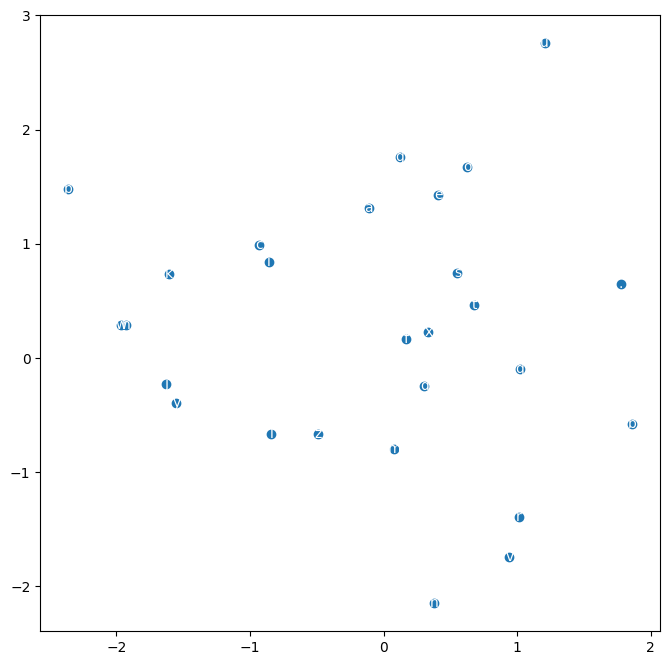

In [252]:
plt.figure(figsize=(8,8))
i=0
C1 = C.cpu().detach().numpy()
plt.scatter(C1[:,0],C1[:,1])
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha="center", va="center", color='white')
# plt.grid('minor')

In [253]:
g = torch.Generator().manual_seed(2147483647)
for i in range(10):
    #forward pass
    out = []
    context = [0] * n_context
    while True:
        emb = C[context]
        preh = emb.view(1,-1) @ W1 + b1
        preh = bgain*(preh - bmean)/ bstd + bbias
        h =  torch.tanh(preh)
        logits= h @ W2 + b2
        p = F.softmax(logits,dim=1)
        ix = torch.multinomial(p,num_samples = 1, replacement = True,generator = g)
        context = context[1:] + [ix.item()]
        if ix.item() == 0:
            break
        out.append(itos[ix.item()])
    print("".join(out))

dex
mariah
makilah
tyha
kalimitta
nella
kama
darre
zylee
tahimion


### Loss log
without any optimization

embedding dimension 2

train loss 1.90

dev loss 2.30

embedding dimension 10

train loss 1.95

dev loss 2.12

kamming init

train loss 2.2

dev loss 2.10

batch norm

In [25]:
10 % 10 

0

In [21]:
import time

In [88]:
print(time.time())
time.sleep(5)
time.time()

1731385180.969165


1731385185.9718242

In [100]:
class NN(torch.nn.Module):
    def __init__(self,n_context,e_dim,h_dim):
        super().__init__()
        self.W1 = torch.randn(n_context*e_dim, h_dim)
        self.b1 = torch.randn(h_dim)
    def forward(self,x):
        out = x.view(-1,n_context*e_dim) @ self.W1 + self.b1
        return out


In [101]:
linera =  NN(n_context,e_dim,h_dim)

In [104]:
linera(emb.view(-1,n_context*e_dim)).shape

torch.Size([32, 200])